# Sunitha Nagrath Lab #

In [1]:
# necesary installs

!pip install pandas numpy tensorflow scikit-learn matplotlib seaborn joblib

# 1. Data Filtering

In [ ]:
## necesarry imports ##

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import decisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [3]:
## open csv files ##

image_number_table = pd.read_csv("MyExpt_Image_Number_w_file.csv")
qc_table = pd.read_csv("MyExpt_FilteredCells_with_Cell_Quality_annotation.csv")

## Filter out B and E

In [4]:
## filter bad images ##

valid_images = image_number_table[image_number_table['Quality'] == 'G']

# debug
print(valid_images['Quality'])
print(valid_images[valid_images['Quality'] != 'G'].size == 0)

7      G
8      G
9      G
10     G
11     G
      ..
266    G
267    G
268    G
269    G
270    G
Name: Quality, Length: 128, dtype: object
True


In [5]:
## merge with QC_table ##

valid_images = pd.merge(valid_images, qc_table, on='ImageNumber', how='left')
print(valid_images.shape)
print(valid_images.iloc[:10, :8])

(5922, 127)
            FileName_DAPI           FileName_FITC            FileName_RFP  \
0  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif  Export_B11_0007_C3.tif   
1  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif  Export_B11_0007_C3.tif   
2  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif  Export_B11_0007_C3.tif   
3  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif  Export_B11_0007_C3.tif   
4  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif  Export_B11_0007_C3.tif   
5  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif  Export_B11_0007_C3.tif   
6  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif  Export_B11_0007_C3.tif   
7  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif  Export_B11_0007_C3.tif   
8  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif  Export_B11_0007_C3.tif   
9  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif  Export_B11_0007_C3.tif   

   ImageNumber Quality  ObjectNumber Quality only bad  AreaShape_Area  
0            8       G             1                P            138

## Model **1**: Logistic Regression With Rows 76-79

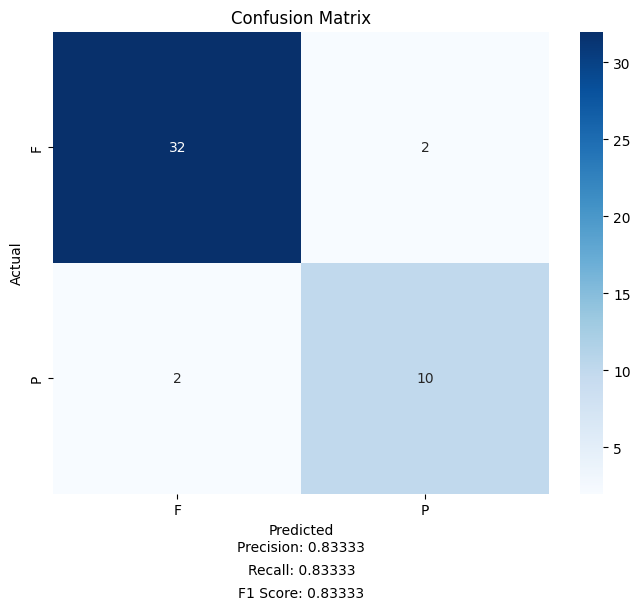

In [6]:
## train a logistic model to determine P (poor quality pictures) ##

### models could be updated to be using a more complex and accurate anomaly detection algorithm if needed ###

## model 1: uses only images 76-79

# train data using labeled data set (images 76 - 79)
train_start = 76
train_end = 79
labeled_data = valid_images[
    (valid_images['ImageNumber'] >= train_start) & 
    (valid_images['ImageNumber'] <= train_end)
]

# convert scientific notations to numeric values
labeled_data.iloc[:, 7:] = labeled_data.iloc[:, 7:].apply(pd.to_numeric, errors='coerce')

# X = features, y = target
X = labeled_data.iloc[:, 7:].values # features
y = labeled_data['Quality only bad'].values  # target

# deal with empty columns (logistic regression does not take NaN values)
nan_columns = np.any(np.isnan(X), axis=0)
nan_indices = np.where(nan_columns)[0]
columns_to_delete = [nan_indices]
X = np.delete(X, columns_to_delete, axis=1)

# assign value for binary ('P' and one other)
y = pd.Series(y)
y.fillna('F', inplace=True) # F for fine quality (vs. poor quality)

# split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# train logistic model
model1 = LogisticRegression()
model1.fit(X_train, y_train)

# predict
y_pred = model1.predict(X_test)

# compute confusion matrix using y_test (true labels for test set) and y_pred
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['F', 'P'], yticklabels=['F', 'P'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
# metrics
precision = precision_score(y_test, y_pred, pos_label='P')
recall = recall_score(y_test, y_pred, pos_label='P')
f1 = f1_score(y_test, y_pred, pos_label='P') # f1 score is reliable for unbalanced data sets like this one
# add metrics to the confusion matrix png
plt.text(0.5, -0.1, f"Precision: {precision:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.15, f"Recall: {recall:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.2, f"F1 Score: {f1:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
# Save the confusion matrix to a file
plt.savefig("Metrics/p_m1_confusion_matrix.png", format='png',bbox_inches='tight')
plt.show()

## Model **2**: Logistic Regression With All Labeled Images

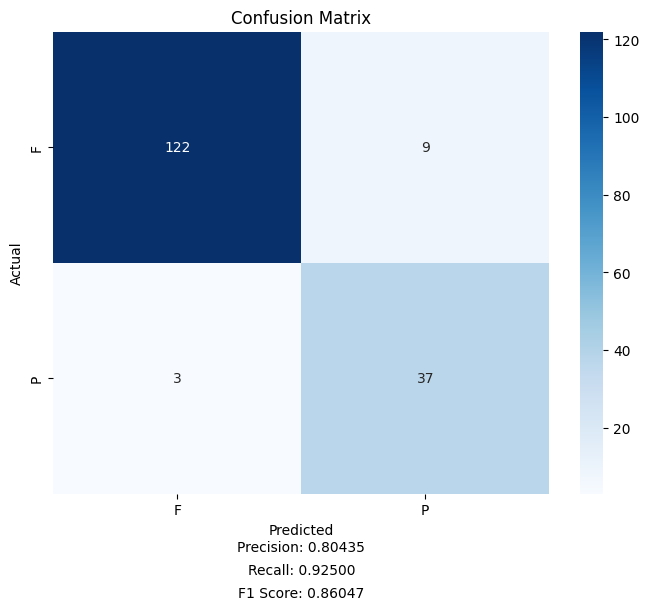

In [7]:
## model 2: uses all images that has 'quality only bad' filled

def log_reg_for_detecting_p(X, y, params=None):
    # Split test and train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train logistic model with custom parameters
    model = LogisticRegression(**params) if params else LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['F', 'P'], yticklabels=['F', 'P'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')

    # Metrics
    precision = precision_score(y_test, y_pred, pos_label='P')
    recall = recall_score(y_test, y_pred, pos_label='P')
    f1 = f1_score(y_test, y_pred, pos_label='P')

    # Add metrics to the confusion matrix plot
    plt.text(0.5, -0.1, f"Precision: {precision:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
    plt.text(0.5, -0.15, f"Recall: {recall:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
    plt.text(0.5, -0.2, f"F1 Score: {f1:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

    # Save the confusion matrix to a file
    plt.savefig("Metrics/p_m2_confusion_matrix.png", format='png', bbox_inches='tight')
    plt.show()
    plt.close()  # Close the figure to free memory

    return model, precision, recall, f1

# Model 2: uses all images that have 'quality only bad' filled
image_filled = valid_images.groupby('ImageNumber')['Quality only bad'].apply(lambda x: (x == 'P').sum())
labeled_data = valid_images[valid_images['ImageNumber'].isin(image_filled[image_filled > 0].index)]

# Convert scientific notations to numeric values
labeled_data.iloc[:, 7:] = labeled_data.iloc[:, 7:].apply(pd.to_numeric, errors='coerce')

# X = features, y = target
X = labeled_data.iloc[:, 7:].values  # features
y = labeled_data['Quality only bad'].values  # target

# Deal with empty columns (logistic regression does not take NaN values)
nan_columns = np.any(np.isnan(X), axis=0)
nan_indices = np.where(nan_columns)[0]
X = np.delete(X, nan_indices, axis=1)

# Assign value for binary ('P' and one other)
y = pd.Series(y)
y.fillna('F', inplace=True)  # F for fine quality (vs. poor quality)

# Example usage with custom parameters
custom_params = {
    'C': 1.0,                # Inverse of regularization strength
    'penalty': 'l2',         # 'l2' for Ridge
    'solver': 'lbfgs',       # Algorithm to use
    'max_iter': 1000,         # Maximum number of iterations
    'class_weight': 'balanced'
}

model2, precision, recall, f1 = log_reg_for_detecting_p(X, y, params=custom_params)

## Model **3**: One-Class SVM with Non-Linear RBF Kernel

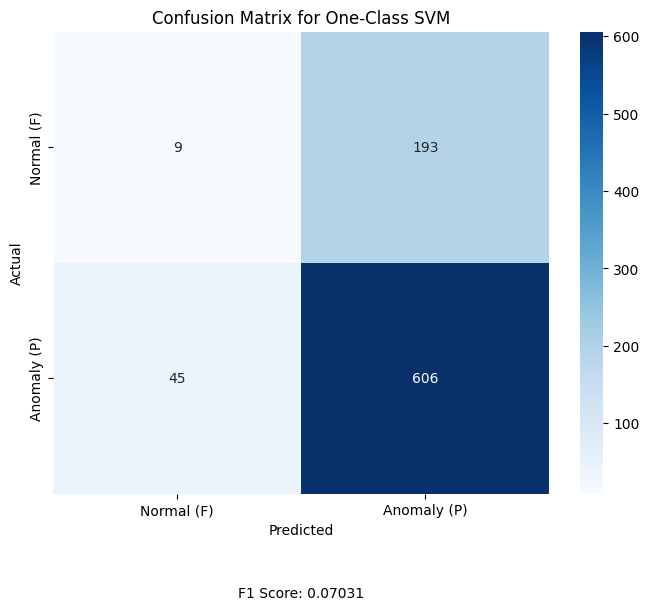

202 853


'\n# Debugging\nprint("Predictions for labeled data:", predictions[labeled_indices])\nprint("True labels for labeled data:", true_labels)\n\n# Check lengths\nprint("Length of true_labels:", len(true_labels))\nprint("Length of predictions for labeled data:", len(predictions[labeled_indices]))\n\n# Unique values\nprint("Unique values in predictions:", np.unique(predictions[labeled_indices]))\nprint("Unique values in true_labels:", np.unique(true_labels))\n\n# Print confusion matrix\nprint("Confusion Matrix:\n", confusion_matrix(true_labels, predictions[labeled_indices]))\n'

In [8]:
# One-class svm
# Pros:
#     1. Works well with high-dementional data sets (datasets that has many X features)
#     2. can do half-supervised learning
# Cons: complex, so only works with small enough data sets (10,000 rows and 70 cols should be fine)

# Retrieve labeled data
p_count = valid_images.groupby('ImageNumber')['Quality only bad'].apply(lambda x: (x == 'P').sum())
labeled_indices = valid_images[valid_images['ImageNumber'].isin(p_count[p_count > 0].index)].index

# Separate labeled and unlabeled data
labeled_data = valid_images.loc[labeled_indices]
unlabeled_data = valid_images.drop(labeled_indices)

# Prepare features, omit empty columns
nan_columns = valid_images.iloc[:, 7:].isna().any()
columns_to_delete = valid_images.columns[7:][nan_columns].tolist()
X_labeled = labeled_data.iloc[:, 7:].drop(columns=columns_to_delete)
X_unlabeled = unlabeled_data.iloc[:, 7:].drop(columns=columns_to_delete)

# Convert scientific notations to numbers
X_labeled = X_labeled.apply(pd.to_numeric, errors='coerce')
X_unlabeled = X_unlabeled.apply(pd.to_numeric, errors='coerce')

# Standardize the data
scaler = StandardScaler()
X_labeled_scaled = scaler.fit_transform(X_labeled)
X_unlabeled_scaled = scaler.transform(X_unlabeled)

# Instantiate the One-Class SVM
model3 = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)

# Fit the model on the labeled data
model3.fit(X_labeled_scaled)

# Make predictions for both labeled and unlabeled data
predictions_labeled = model3.predict(X_labeled_scaled)  # 1 for normal, -1 for anomaly
predictions_unlabeled = model3.predict(X_unlabeled_scaled)

# Combine predictions
predictions = np.full(len(valid_images), 1)  # Initialize as normal (1)
predictions[labeled_indices] = predictions_labeled
predictions[unlabeled_data.index] = predictions_unlabeled

# Prepare true labels for evaluation: Convert 'P' to -1 (anomaly) and 'F' to 1 (normal)
true_labels = np.where(labeled_data['Quality only bad'] == 'P', -1, 1)

# Calculate confusion matrix for the labeled data only
conf_matrix = confusion_matrix(true_labels, predictions[labeled_indices])

# Calculate f1-score
f1 = f1_score(true_labels, predictions[labeled_indices], pos_label=-1)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal (F)', 'Anomaly (P)'], 
            yticklabels=['Normal (F)', 'Anomaly (P)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for One-Class SVM')

# Save confusion matrix
plt.savefig("Metrics/p_m3_confusion_matrix.png", format='png', bbox_inches='tight')
plt.text(0.5, -0.2, f"F1 Score: {f1:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.show()

p_count = np.sum(predictions[labeled_indices] == -1)
p_count = np.sum(true_labels == -1)
total_count = np.count_nonzero(true_labels)
print(p_count, total_count)

'''
# Debugging
print("Predictions for labeled data:", predictions[labeled_indices])
print("True labels for labeled data:", true_labels)

# Check lengths
print("Length of true_labels:", len(true_labels))
print("Length of predictions for labeled data:", len(predictions[labeled_indices]))

# Unique values
print("Unique values in predictions:", np.unique(predictions[labeled_indices]))
print("Unique values in true_labels:", np.unique(true_labels))

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(true_labels, predictions[labeled_indices]))
'''


## Predict all P

In [9]:
## apply model to the unlabeled rows and filter out P ##


#### model 2 had slightly better f1 score, so use model 2

unlabeled_data = valid_images.copy()

# convert scientific notations to numeric values
unlabeled_data.iloc[:, 7:] = unlabeled_data.iloc[:, 7:].apply(pd.to_numeric, errors='coerce')

# X = features
X_unlabeled = unlabeled_data.iloc[:, 7:].values

# Deal with empty columns (logistic regression does not take NaN values)
nan_columns = np.any(np.isnan(X_unlabeled), axis=0)
nan_indices = np.where(nan_columns)[0]
X_unlabeled = np.delete(X_unlabeled, nan_indices, axis=1)

# scale the features
X_unlabeled = scaler.transform(X_unlabeled)

# predict
predictions = model2.predict(X_unlabeled)

valid_images.loc[:, 'Quality only bad'] = predictions

# debug
print("number of Ps predicted: ", predictions[predictions == 'P'].size)
print("number of Ps actualy predicted:\n", valid_images[valid_images['Quality only bad'] == 'P']['Quality only bad'])

number of Ps predicted:  1183
number of Ps actualy predicted:
 0       P
1       P
4       P
5       P
7       P
       ..
5877    P
5884    P
5885    P
5887    P
5918    P
Name: Quality only bad, Length: 1183, dtype: object


/home/tyoneyam/miniforge3/envs/jupyter_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Filter out P

In [10]:
valid_cells = valid_images[valid_images['Quality only bad'] != 'P'] # filtering

# debug
print(valid_cells['Quality only bad'])
print(valid_cells[valid_cells['Quality only bad'] == 'P'].size == 0)

valid_cells.to_csv('filtered_out_ebp.csv')

2       F
3       F
6       F
8       F
9       F
       ..
5916    F
5917    F
5919    F
5920    F
5921    F
Name: Quality only bad, Length: 4739, dtype: object
True


## Merge Membrane and Nuclei Features

In [11]:
# add annotation column
membrane_data = valid_cells.copy()
membrane_data.insert(7, 'Annotation', '')
membrane_data['Annotation'] = membrane_data['FileName_DAPI'].apply(
    lambda x: 'M' if 'B11' in x or 'C10' in x else ('E' if 'C11' in x or 'D10' in x else None)
)

print(membrane_data.iloc[:3, :8])

            FileName_DAPI           FileName_FITC            FileName_RFP  \
2  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif  Export_B11_0007_C3.tif   
3  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif  Export_B11_0007_C3.tif   
6  Export_B11_0007_C1.tif  Export_B11_0007_C2.tif  Export_B11_0007_C3.tif   

   ImageNumber Quality  ObjectNumber Quality only bad Annotation  
2            8       G             3                F          M  
3            8       G             4                F          M  
6            8       G             7                F          M  


In [12]:
# drop unecessary columns
columns_to_drop = ['FileName_DAPI', 'FileName_FITC', 'FileName_RFP', 'Quality', 'Quality only bad']
membrane_data = membrane_data.drop(columns=columns_to_drop, axis=1)

print(membrane_data.iloc[:3, :5])

   ImageNumber  ObjectNumber Annotation  AreaShape_Area  \
2            8             3          M            6986   
3            8             4          M            5513   
6            8             7          M            4176   

   AreaShape_BoundingBoxArea  
2                      13005  
3                      11286  
6                       7392  


In [13]:
### from here, c&p from yuru's code with variable names and ranges adjusted to my code ###


nucleus_data = pd.read_csv('MyExpt_Final_Nuclei.csv')

# mod col name to decifer between nuclei and membrine features
nucleus_data.columns = list(nucleus_data.columns[:2]) + ['Nue.' + col for col in nucleus_data.columns[2:]]
membrane_data.columns = list(membrane_data.columns[:3]) + ['Memb.' + col for col in membrane_data.columns[3:]]

print(nucleus_data.iloc[:3, :5])
print(membrane_data.iloc[:3, :5])

   ImageNumber  ObjectNumber  Nue.AreaShape_Area  \
0            1             1                 447   
1            1             2                 522   
2            1             3                 422   

   Nue.AreaShape_BoundingBoxArea  Nue.AreaShape_BoundingBoxMaximum_X  
0                            576                                 221  
1                            702                                1871  
2                            546                                 281  
   ImageNumber  ObjectNumber Annotation  Memb.AreaShape_Area  \
2            8             3          M                 6986   
3            8             4          M                 5513   
6            8             7          M                 4176   

   Memb.AreaShape_BoundingBoxArea  
2                           13005  
3                           11286  
6                            7392  


In [14]:
membrane_data = membrane_data.reset_index()  # If needed
nucleus_data = nucleus_data.reset_index()    # If needed

# debug
print(membrane_data.columns)
print(nucleus_data.columns)

Index(['index', 'ImageNumber', 'ObjectNumber', 'Annotation',
       'Memb.AreaShape_Area', 'Memb.AreaShape_BoundingBoxArea',
       'Memb.AreaShape_BoundingBoxMaximum_X',
       'Memb.AreaShape_BoundingBoxMaximum_Y',
       'Memb.AreaShape_BoundingBoxMinimum_X',
       'Memb.AreaShape_BoundingBoxMinimum_Y',
       ...
       'Memb.Location_Center_Y', 'Memb.Location_Center_Z',
       'Memb.Mean_FilteredNuclei__Children_Cells_Count',
       'Memb.Mean_FilteredNuclei__Distance_Centroid_FilteredCells',
       'Memb.Mean_FilteredNuclei__Location_Center_X',
       'Memb.Mean_FilteredNuclei__Location_Center_Y',
       'Memb.Mean_FilteredNuclei__Location_Center_Z',
       'Memb.Mean_FilteredNuclei__Number_Object_Number',
       'Memb.Number_Object_Number', 'Memb.Parent_Cells'],
      dtype='object', length=124)
Index(['index', 'ImageNumber', 'ObjectNumber', 'Nue.AreaShape_Area',
       'Nue.AreaShape_BoundingBoxArea', 'Nue.AreaShape_BoundingBoxMaximum_X',
       'Nue.AreaShape_BoundingBoxMaxim

In [15]:
# merge (make sure to make membrane_data the LEFT table since we only need valid cells)
final_combined_data = pd.merge(membrane_data, nucleus_data, 
                         on=['ImageNumber', 'ObjectNumber'],  # 确保右侧也正确命名
                         how='left').drop('index_x', axis=1)

print(final_combined_data.head())
final_combined_data.to_csv('Combined_Data.csv', index=False)

   ImageNumber  ObjectNumber Annotation  Memb.AreaShape_Area  \
0            8             3          M                 6986   
1            8             4          M                 5513   
2            8             7          M                 4176   
3            8             9          M                 1885   
4            8            10          M                 3466   

   Memb.AreaShape_BoundingBoxArea  Memb.AreaShape_BoundingBoxMaximum_X  \
0                           13005                                  641   
1                           11286                                 1899   
2                            7392                                 1694   
3                            3132                                   93   
4                            5250                                  675   

   Memb.AreaShape_BoundingBoxMaximum_Y  Memb.AreaShape_BoundingBoxMinimum_X  \
0                                  144                                  488   
1           

# Train Model for EM Detection

## Model 1: Logistic Regression

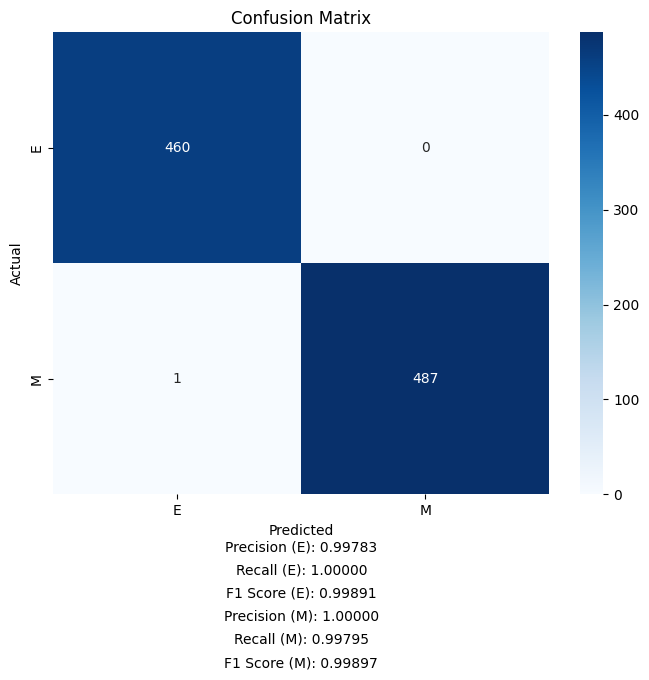

In [16]:
def log_reg_for_em(X, y, params=None):
    # Split test and train sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train logistic regression model with custom parameters
    model = LogisticRegression(**params) if params else LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=['E', 'M'])

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'M'], yticklabels=['E', 'M'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')

    # Calculate precision, recall, and F1 score for each class
    precision_e = precision_score(y_test, y_pred, pos_label='E', average='binary')
    recall_e = recall_score(y_test, y_pred, pos_label='E', average='binary')
    f1_e = f1_score(y_test, y_pred, pos_label='E', average='binary')

    # Display metrics for 'E' state in the plot
    plt.text(0.5, -0.1, f"Precision (E): {precision_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
    plt.text(0.5, -0.15, f"Recall (E): {recall_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
    plt.text(0.5, -0.2, f"F1 Score (E): {f1_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

    # Calculate metrics for 'M' state
    precision_m = precision_score(y_test, y_pred, pos_label='M', average='binary')
    recall_m = recall_score(y_test, y_pred, pos_label='M', average='binary')
    f1_m = f1_score(y_test, y_pred, pos_label='M', average='binary')

    # Display metrics for 'M' state in the plot
    plt.text(0.5, -0.25, f"Precision (M): {precision_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
    plt.text(0.5, -0.3, f"Recall (M): {recall_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
    plt.text(0.5, -0.35, f"F1 Score (M): {f1_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

    # Save the confusion matrix plot
    plt.savefig("Metrics/em_m1_confusion_matrix.png", format='png', bbox_inches='tight')
    plt.show()
    plt.close()  # Free memory by closing figure

    return model, (precision_e, recall_e, f1_e), (precision_m, recall_m, f1_m)

# X and y
X = final_combined_data.iloc[:, 5:].dropna(axis=1)
y = final_combined_data["Annotation"]

# use def: train_and_evaluate_logistic_regression
custom_params = {
    'C': 1.0,                # Inverse of regularization strength
    'penalty': 'l2',         # 'l2' for Ridge
    'solver': 'lbfgs',       # Algorithm to use
    'max_iter': 1000,         # Maximum number of iterations
    'class_weight': 'balanced'
}

em_model1, (precision_e, recall_e, f1_e), (precision_m, recall_m, f1_m) = log_reg_for_em(X, y, params=custom_params)

## Model 2: Yuru's Model

In [17]:
# before applying Yuru's model, match my dataset's features to Yuru's

yuru_data_set = pd.read_csv("yuru_final_combined_data.csv")
yuru_input = yuru_data_set.filter(regex=r'^(Neu\.|Memb\.)')
my_input = final_combined_data.filter(regex=r'^(Neu\.|Memb\.)')

my_input_reordered = my_input[yuru_input.columns]

print(my_input_reordered.columns == yuru_input.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]


In [18]:
# load pkls
# 加载模型
loaded_model = joblib.load('100824logistic_regression_model.pkl')

# 加载标准化器
loaded_scaler = joblib.load('100824scaler.pkl')

/home/tyoneyam/miniforge3/envs/jupyter_env/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/tyoneyam/miniforge3/envs/jupyter_env/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [19]:
# match my_input to scalar input

# Get columns in scaler but not in reordered input
missing_in_input = set(loaded_scaler.feature_names_in_) - set(my_input_reordered.columns)
# Get columns in reordered input but not in scaler
extra_in_input = set(my_input_reordered.columns) - set(loaded_scaler.feature_names_in_)

print("Features in scaler but missing in input:", missing_in_input)
print("Features in input but missing in scaler:", extra_in_input)

my_input_reordered = my_input_reordered.drop(columns=list(extra_in_input), axis=1)

print(loaded_scaler.feature_names_in_ == my_input_reordered.columns)

Features in scaler but missing in input: set()
Features in input but missing in scaler: {'Memb.AreaShape_NormalizedMoment_0_1', 'Memb.AreaShape_NormalizedMoment_0_0', 'Memb.AreaShape_NormalizedMoment_1_0', 'Memb.AreaShape_BoundingBoxMinimum_X', 'Memb.AreaShape_BoundingBoxMinimum_Y', 'Memb.AreaShape_EulerNumber', 'Memb.AreaShape_BoundingBoxMaximum_Y', 'Memb.AreaShape_BoundingBoxMaximum_X', 'Memb.Number_Object_Number', 'Memb.Location_Center_Z', 'Memb.Parent_Cells'}
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  T

/home/tyoneyam/miniforge3/envs/jupyter_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


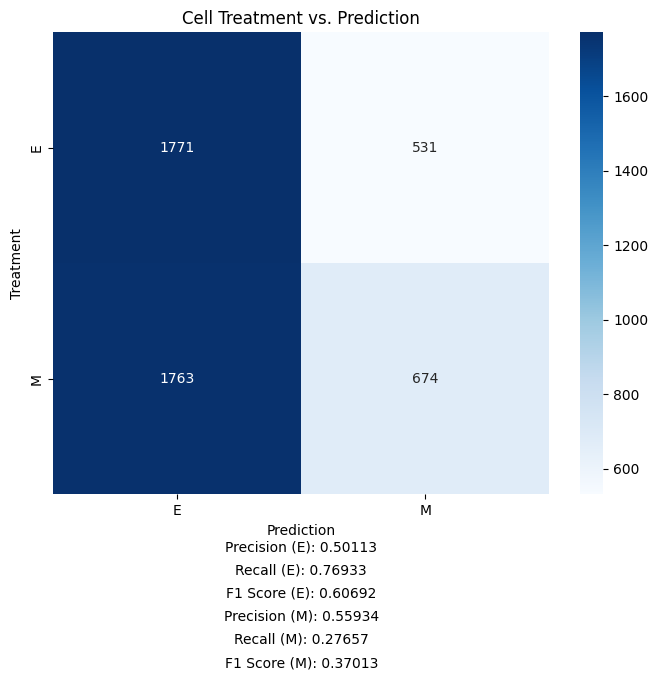

In [20]:
# prepare X and y
X = final_combined_data[my_input_reordered.columns].values

# 重新使用标准化后的数据进行预测
X_scaled = loaded_scaler.transform(X)
y_pred_loaded = loaded_model.predict(X_scaled)

# Compute the confusion matrix
cell_treatments = final_combined_data['Annotation'].values
cm = confusion_matrix(cell_treatments, y_pred_loaded, labels=['E', 'M'])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'M'], yticklabels=['E', 'M'])
plt.ylabel('Treatment')
plt.xlabel('Prediction')
plt.title('Cell Treatment vs. Prediction')

# Calculate precision, recall, and F1 score for each class
precision_e = precision_score(cell_treatments, y_pred_loaded, pos_label='E', average='binary')
recall_e = recall_score(cell_treatments, y_pred_loaded, pos_label='E', average='binary')
f1_e = f1_score(cell_treatments, y_pred_loaded, pos_label='E', average='binary')

# Display metrics for 'E' state in the plot
plt.text(0.5, -0.1, f"Precision (E): {precision_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.15, f"Recall (E): {recall_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.2, f"F1 Score (E): {f1_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Calculate metrics for 'M' state
precision_m = precision_score(cell_treatments, y_pred_loaded, pos_label='M', average='binary')
recall_m = recall_score(cell_treatments, y_pred_loaded, pos_label='M', average='binary')
f1_m = f1_score(cell_treatments, y_pred_loaded, pos_label='M', average='binary')

# Display metrics for 'M' state in the plot
plt.text(0.5, -0.25, f"Precision (M): {precision_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.3, f"Recall (M): {recall_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.35, f"F1 Score (M): {f1_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Save the confusion matrix plot
plt.savefig("Metrics/em_m2_treatment_vs_prediction_confusion_matrix.png", format='png', bbox_inches='tight')
plt.show()
plt.close()  # Free memory by closing figure

## Calculate EM Score

In [21]:
# calculate EM score
y_probs = loaded_model.predict_proba(X_scaled)[:, 1]  # 取 E 类别的概率
A = pd.DataFrame(final_combined_data)
A['EM_Score'] = y_probs
# predicted result
A['Predicted_Annotation'] = y_pred_loaded
# treatment
A['Treatment'] = final_combined_data['Annotation']
columns_to_consider = ['ImageNumber', 'ObjectNumber', 'EM_Score', 'Predicted_Annotation', 'Treatment']
print(A[columns_to_consider])
A[columns_to_consider].to_csv('em_score_for_yuru_logistic_regression_on_final_combined_data.csv', index=False)

      ImageNumber  ObjectNumber  EM_Score Predicted_Annotation Treatment
0               8             3  0.027104                    E         M
1               8             4  0.061170                    E         M
2               8             7  0.037094                    E         M
3               8             9  0.000466                    E         M
4               8            10  0.000202                    E         M
...           ...           ...       ...                  ...       ...
4734          271            27  0.788423                    M         E
4735          271            28  0.021857                    E         E
4736          271            30  0.001107                    E         E
4737          271            31  0.111401                    E         E
4738          271            32  0.010424                    E         E

[4739 rows x 5 columns]


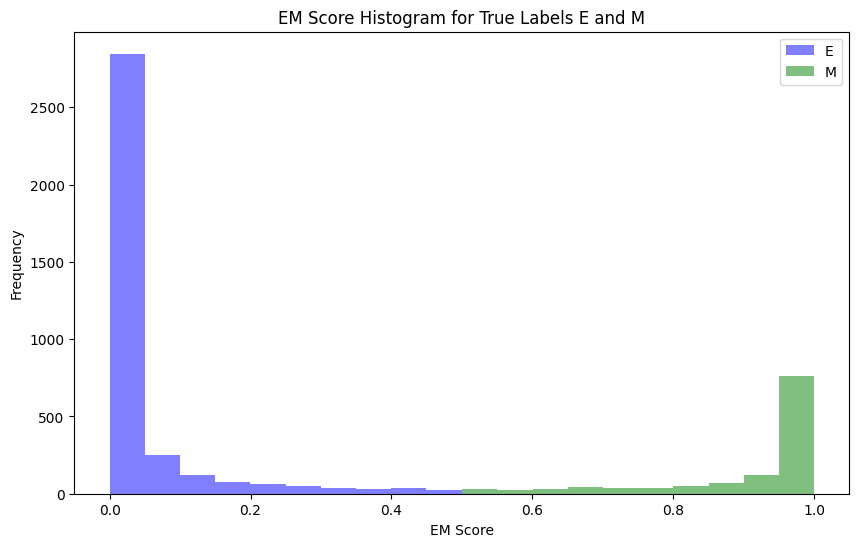

'\n## Scatterplot\n\n# Set colors for the annotations\ncolors = [\'green\' if label == \'M\' else \'blue\' for label in A[\'True_Annotation\'][:min_length]]\n\n# Plot scatter plot\nplt.figure(figsize=(8, 6))\nplt.scatter(m_scores, e_scores, c=colors, alpha=0.7, edgecolor=\'k\')\nplt.title(\'Scatter Plot of EM_Score (M) vs EM_Score (E)\')\nplt.xlabel(\'EM_Score (M)\')\nplt.ylabel(\'EM_Score (E)\')\nplt.grid(True)\n# save plot\nplt.savefig("Metrics/em_score_scatter_plot.png", format=\'png\', bbox_inches=\'tight\')\n# Show the plot\nplt.show()\nplt.close()\n'

In [22]:
# Visualize EM Score (Histogram and Scatterplot)

## Histogram

# Separate data based on the True_label being 'E' or 'M'
e_scores = A[A['Predicted_Annotation'] == 'E']['EM_Score']
m_scores = A[A['Predicted_Annotation'] == 'M']['EM_Score']
# Create the histograms
plt.figure(figsize=(10,6))
plt.hist(e_scores, bins=10, alpha=0.5, label='E', color='blue')
plt.hist(m_scores, bins=10, alpha=0.5, label='M', color='green')
# Add titles and labels
plt.title('EM Score Histogram for True Labels E and M')
plt.xlabel('EM Score')
plt.ylabel('Frequency')
# Add a legend
plt.legend()
# save plot
plt.savefig("Metrics/em_score_histogram.png", format='png', bbox_inches='tight')
# Show the plot
plt.show()
plt.close()

'''
## Scatterplot

# Set colors for the annotations
colors = ['green' if label == 'M' else 'blue' for label in A['True_Annotation'][:min_length]]

# Plot scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(m_scores, e_scores, c=colors, alpha=0.7, edgecolor='k')
plt.title('Scatter Plot of EM_Score (M) vs EM_Score (E)')
plt.xlabel('EM_Score (M)')
plt.ylabel('EM_Score (E)')
plt.grid(True)
# save plot
plt.savefig("Metrics/em_score_scatter_plot.png", format='png', bbox_inches='tight')
# Show the plot
plt.show()
plt.close()
'''

# Adjusting the Model

## PCA

first, do pca to identify important features

### Get E and M annotations on the original data

In [23]:
# load data,model,scalar
yuru_data_set = pd.read_csv("yuru_final_combined_data.csv")
loaded_model = joblib.load('100824logistic_regression_model.pkl')
loaded_scaler = joblib.load('100824scaler.pkl')

/home/tyoneyam/miniforge3/envs/jupyter_env/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/tyoneyam/miniforge3/envs/jupyter_env/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [24]:
# select only rows with annotations
yuru_valid_rows = yuru_data_set[yuru_data_set['Annotation'].notna()]

# print the annotation column
print(yuru_valid_rows['Annotation'])

3      M
6      M
7      M
11     M
14     M
      ..
432    M
435    M
440    M
458    M
462    M
Name: Annotation, Length: 135, dtype: object


In [25]:
# match features to scalar

yuru_input = yuru_valid_rows.filter(regex=r'^(Neu\.|Memb\.)')

# Get columns in scaler but not in reordered input
missing_in_input = set(loaded_scaler.feature_names_in_) - set(yuru_input.columns)
# Get columns in reordered input but not in scaler
extra_in_input = set(yuru_input.columns) - set(loaded_scaler.feature_names_in_)

print("Features in scaler but missing in input:", missing_in_input)
print("Features in input but missing in scaler:", extra_in_input)

yuru_input = yuru_input.drop(columns=list(extra_in_input), axis=1)

print(loaded_scaler.feature_names_in_ == yuru_input.columns)

Features in scaler but missing in input: set()
Features in input but missing in scaler: {'Memb.AreaShape_NormalizedMoment_0_1', 'Memb.AreaShape_NormalizedMoment_0_0', 'Memb.AreaShape_NormalizedMoment_1_0', 'Memb.AreaShape_BoundingBoxMinimum_X', 'Memb.AreaShape_BoundingBoxMinimum_Y', 'Memb.AreaShape_EulerNumber', 'Memb.AreaShape_BoundingBoxMaximum_Y', 'Memb.AreaShape_BoundingBoxMaximum_X', 'Memb.Number_Object_Number', 'Memb.Location_Center_Z', 'Memb.Parent_Cells'}
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  T

In [26]:
# prepare features
X = yuru_input.values

# apply scalar
X_scaled = loaded_scaler.transform(X)

# find the index of the 'Memb.AreaShape_Area' column
column_index = yuru_input.columns.get_loc('Memb.AreaShape_Area')

# print the scaled values of the 'Memb.AreaShape_Area' column
# print(X_scaled[:, column_index])

/home/tyoneyam/miniforge3/envs/jupyter_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [27]:
# debug

# find and print columns containing nan values
nan_columns = np.any(np.isnan(X_scaled), axis=0)
nan_indices = np.where(nan_columns)[0]
columns_with_nan = yuru_input.columns[nan_indices]
print("Columns with NaN values:", columns_with_nan)


# find and print rows containing nan values
nan_rows = np.any(np.isnan(X_scaled), axis=1)
nan_indices = np.where(nan_rows)[0]
print("Rows with NaN values:", nan_indices)


Columns with NaN values: Index([], dtype='object')
Rows with NaN values: []


In [28]:
# make prediction
y_pred_loaded = loaded_model.predict(X_scaled)

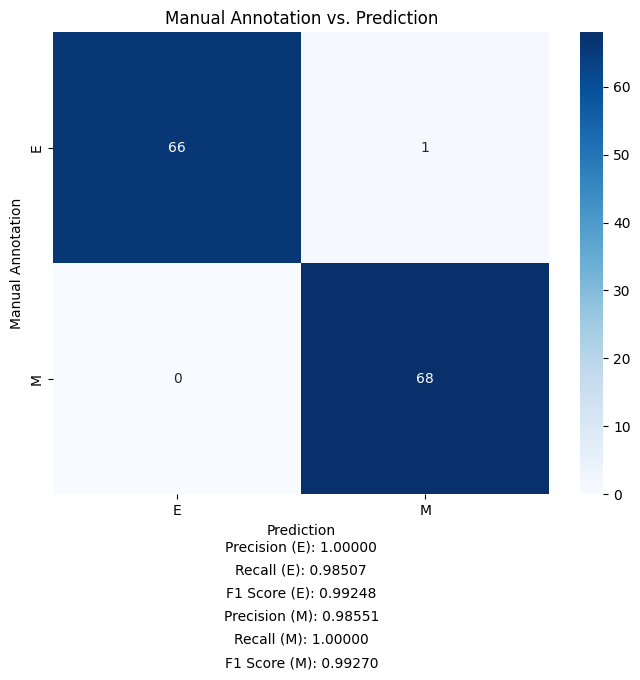

In [29]:
# visualize
# C&P from Model 2: Loaded Yuru's Model

# from yuru_data_set, select 'Annotation' where it is not NaN as an np array
manually_inputed_annotations = yuru_valid_rows['Annotation'].values
cm = confusion_matrix(manually_inputed_annotations, y_pred_loaded, labels=['E', 'M'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'M'], yticklabels=['E', 'M'])
plt.ylabel('Manual Annotation')
plt.xlabel('Prediction')
plt.title('Manual Annotation vs. Prediction')

precision_e = precision_score(manually_inputed_annotations, y_pred_loaded, pos_label='E', average='binary')
recall_e = recall_score(manually_inputed_annotations, y_pred_loaded, pos_label='E', average='binary')
f1_e = f1_score(manually_inputed_annotations, y_pred_loaded, pos_label='E', average='binary')

plt.text(0.5, -0.1, f"Precision (E): {precision_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.15, f"Recall (E): {recall_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.2, f"F1 Score (E): {f1_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

precision_m = precision_score(manually_inputed_annotations, y_pred_loaded, pos_label='M', average='binary')
recall_m = recall_score(manually_inputed_annotations, y_pred_loaded, pos_label='M', average='binary')
f1_m = f1_score(manually_inputed_annotations, y_pred_loaded, pos_label='M', average='binary')

plt.text(0.5, -0.25, f"Precision (M): {precision_m:.5f}", ha='center'
, va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.3, f"Recall (M): {recall_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.35, f"F1 Score (M): {f1_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

plt.show()
# save figure to png
plt.savefig("Metrics/pca_manual_vs_prediction_confusion_matrix.png", format='png', bbox_inches='tight')
plt.close()  # Free memory by closing figure

### Calculate EM Score

In [30]:
# calculate EM score
y_probs = loaded_model.predict_proba(X_scaled)[:, 1]
yuru_data_with_em_score = yuru_data_set[yuru_data_set['Annotation'].notna()]

# EM score
yuru_data_with_em_score.loc[:, 'EM_Score'] = y_probs
# predicted result
yuru_data_with_em_score.loc[:, 'Predicted_Annotation'] = y_pred_loaded
# treatment
yuru_data_with_em_score.loc[:, 'Treatment'] = manually_inputed_annotations

columns_to_consider = ['ImageNumber', 'ObjectNumber_x', 'EM_Score', 'Predicted_Annotation', 'Treatment']
print(yuru_data_with_em_score[columns_to_consider])
yuru_data_with_em_score[columns_to_consider].to_csv('em_score_for_logistic_regression_on_yuru_data.csv', index=False)

     ImageNumber  ObjectNumber_x  EM_Score Predicted_Annotation Treatment
3              1               4  0.986141                    M         M
6              1               7  0.999787                    M         M
7              1               8  0.999994                    M         M
11             1              12  0.999515                    M         M
14             1              15  0.996619                    M         M
..           ...             ...       ...                  ...       ...
432            8              18  0.979006                    M         M
435            8              21  0.998791                    M         M
440            8              26  0.896740                    M         M
458            8              44  0.998145                    M         M
462            8              48  0.999998                    M         M

[135 rows x 5 columns]


/tmp/ipykernel_13606/3345101314.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yuru_data_with_em_score.loc[:, 'EM_Score'] = y_probs
/tmp/ipykernel_13606/3345101314.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yuru_data_with_em_score.loc[:, 'Predicted_Annotation'] = y_pred_loaded
/tmp/ipykernel_13606/3345101314.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [31]:
# print yuru_data_with_em_score where annotation = E
print(yuru_data_with_em_score[yuru_data_with_em_score['Annotation'] == 'E'][columns_to_consider])

# print yuru_data_with_em_score where annotation = M
print(yuru_data_with_em_score[yuru_data_with_em_score['Annotation'] == 'M'][columns_to_consider])

     ImageNumber  ObjectNumber_x  EM_Score Predicted_Annotation Treatment
167            1               3  0.001522                    E         E
168            1               4  0.000134                    E         E
169            1               5  0.000655                    E         E
170            1               6  0.012674                    E         E
171            1               7  0.000025                    E         E
..           ...             ...       ...                  ...       ...
325            4              47  0.001013                    E         E
335            4              57  0.000056                    E         E
339            4              61  0.000741                    E         E
342            4              64  0.000754                    E         E
348            4              70  0.068816                    E         E

[67 rows x 5 columns]
     ImageNumber  ObjectNumber_x  EM_Score Predicted_Annotation Treatment
3              

### PCA

In [ ]:
# apply pca on yuru_data_with_em_score

# PCA (Principal Component Analysis) is a dimensionality reduction technique 
# that transforms the data into a new coordinate system, where the axes 
# (principal components) correspond to directions of maximum variance in the data.

# create PCA model
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# X_pca would have a shape of (n_samples, n_components)
print("n_samples = ", X_scaled.shape[0])
print("X_pca shape: ", X_pca.shape)

# y = annotation
y = yuru_data_with_em_score['Annotation'].values

n_samples =  135
X_pca shape:  (135, 2)


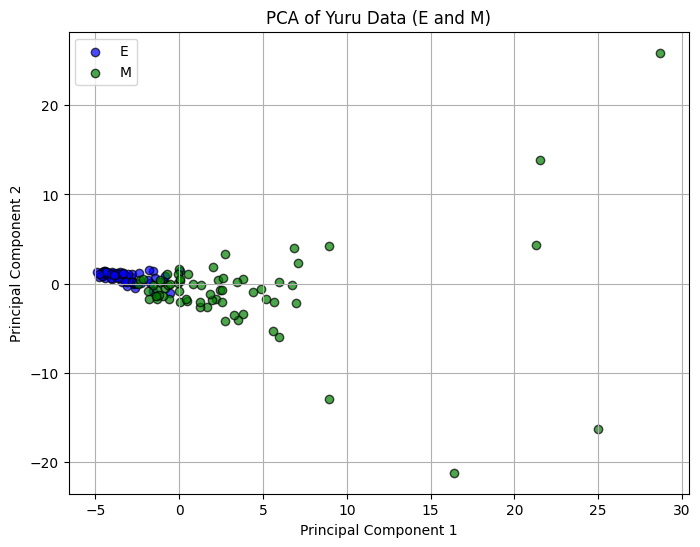

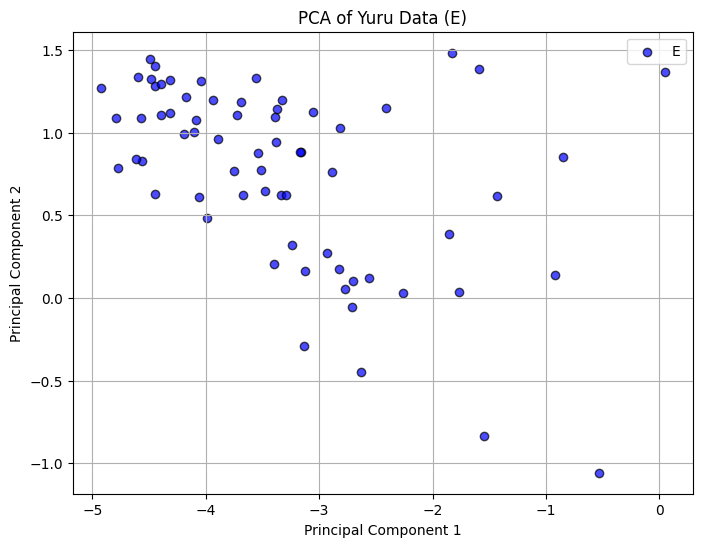

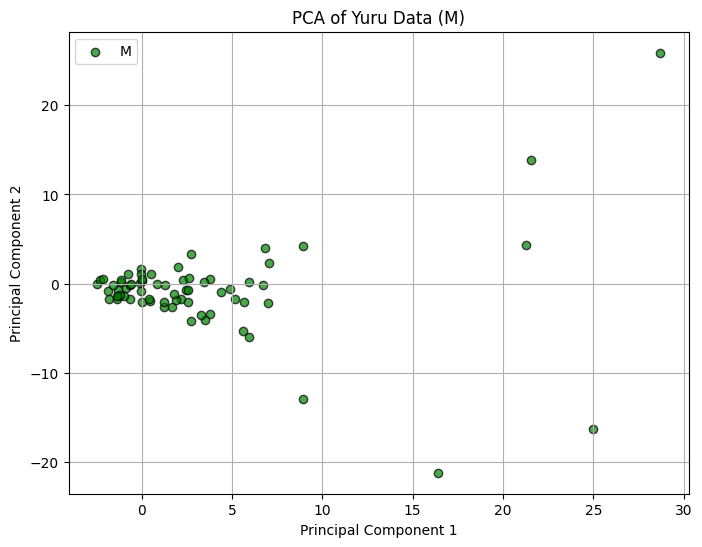

In [ ]:
# plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 'E', 0], X_pca[y == 'E', 1], c='blue', label='E', alpha=0.7, edgecolor='k')
plt.scatter(X_pca[y == 'M', 0], X_pca[y == 'M', 1], c='green', label='M', alpha=0.7, edgecolor='k')
plt.title('PCA of Yuru Data (E and M)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
# save plot
plt.savefig("Metrics/pca_on_yuru_data.png", format='png', bbox_inches='tight')
plt.close()

# plot for only E
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 'E', 0], X_pca[y == 'E', 1], c='blue', label='E', alpha=0.7, edgecolor='k')
plt.title('PCA of Yuru Data (E)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
# save plot
plt.savefig("Metrics/pca_on_yuru_data_only_E.png", format='png', bbox_inches='tight')
plt.close()

# plot for only M
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 'M', 0], X_pca[y == 'M', 1], c='green', label='M', alpha=0.7, edgecolor='k')
plt.title('PCA of Yuru Data (M)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
# save plot
plt.savefig("Metrics/pca_on_yuru_data_only_M.png", format='png', bbox_inches='tight')
plt.close()

The plot shows that Principle Component 1 successfully separates E and M

In [6]:
# figure out what features were classified as Principle Component 1
# get the first principal component
first_pc = pca.components_[0]

# print the first principal component
print("First Principal Component: ", first_pc)

NameError: name 'pca' is not defined

### PLS-DA

In [ ]:
# PLS-DA (Partial Least Squares Discriminant Analysis) is a supervised method
# that projects the data into a new coordinate system that maximizes the separation
# between classes. It is often used for classification tasks.

# basically a supervised version of PCA

# Encode the annotations to numerical values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Create PLS-DA model
pls_da = PLSRegression(n_components=2)
X_pls_da = pls_da.fit_transform(X_scaled, y_encoded)[0]

# X_pls_da would have a shape of (n_samples, n_components)
print("n_samples = ", X_scaled.shape[0])
print("X_pls_da shape: ", X_pls_da.shape)

# y = annotation
y = yuru_data_with_em_score['Annotation'].values

n_samples =  135
X_pls_da shape:  (135, 2)


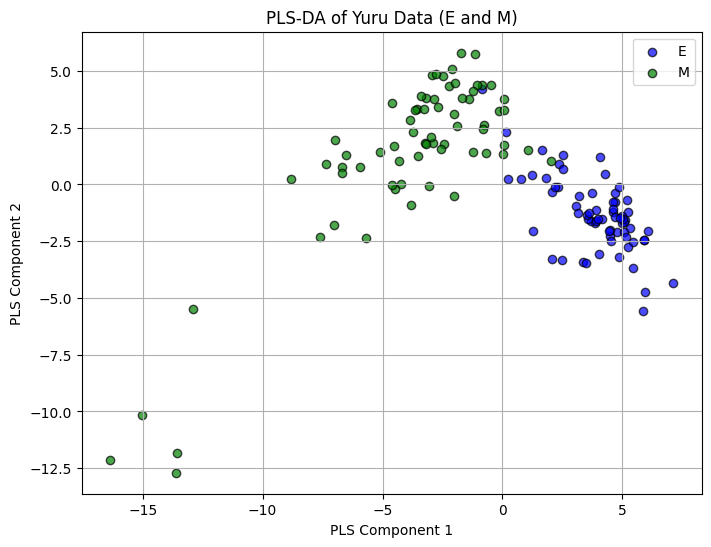

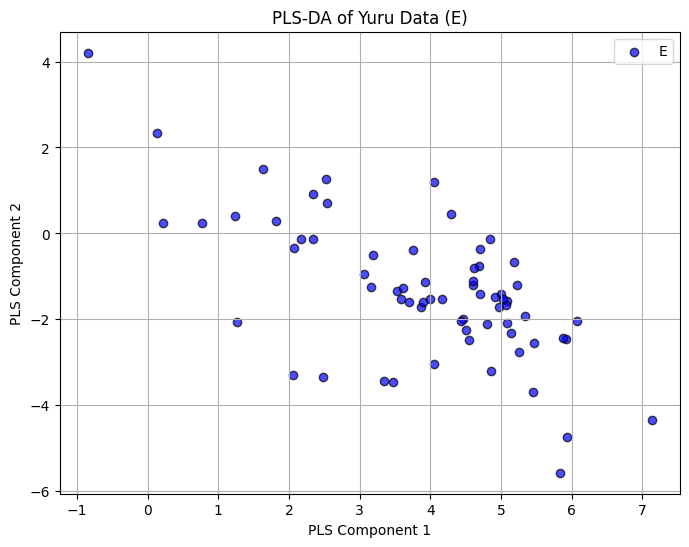

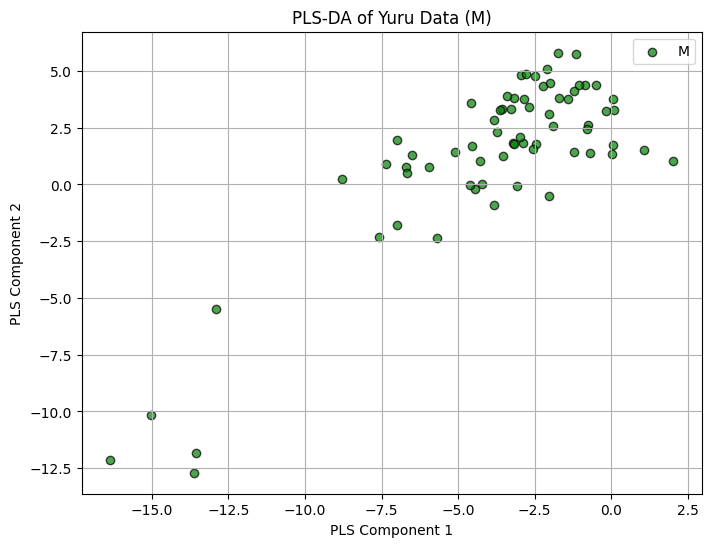

In [55]:
# plot the PLS-DA results
plt.figure(figsize=(8, 6))
plt.scatter(X_pls_da[y == 'E', 0], X_pls_da[y == 'E', 1], c='blue', label='E', alpha=0.7, edgecolor='k')
plt.scatter(X_pls_da[y == 'M', 0], X_pls_da[y == 'M', 1], c='green', label='M', alpha=0.7, edgecolor='k')
plt.title('PLS-DA of Yuru Data (E and M)')
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.legend()
plt.grid(True)
plt.show()
# save plot
plt.savefig("Metrics/pls_da_on_yuru_data.png", format='png', bbox_inches='tight')
plt.close()

# plot for only E
plt.figure(figsize=(8, 6))
plt.scatter(X_pls_da[y == 'E', 0], X_pls_da[y == 'E', 1], c='blue', label='E', alpha=0.7, edgecolor='k')
plt.title('PLS-DA of Yuru Data (E)')
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.legend()
plt.grid(True)
plt.show()
# save plot
plt.savefig("Metrics/pls_da_on_yuru_data_only_E.png", format='png', bbox_inches='tight')
plt.close()

# plot for only M
plt.figure(figsize=(8, 6))
plt.scatter(X_pls_da[y == 'M', 0], X_pls_da[y == 'M', 1], c='green', label='M', alpha=0.7, edgecolor='k')
plt.title('PLS-DA of Yuru Data (M)')
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.legend()
plt.grid(True)
plt.show()
# save plot
plt.savefig("Metrics/pls_da_on_yuru_data_only_M.png", format='png', bbox_inches='tight')
plt.close()

## Normalize Data

### Code by: Yuru Chen, Touma Yoneyama